In [296]:
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, Matern
from sklearn.ensemble.forest import RandomForestRegressor

In [9]:
sklearn.__version__ 

'0.18.1'

# DATA IMPORTING AND CLEANING

# Creating Data Tables from Files

In [10]:
organics = pd.read_csv('organics.csv', encoding = "ISO-8859-1")

In [11]:
organics.head()

,"Table 5. Concentrations of selected anions, ammonium, and nitrous oxide in groundwater samples collected from wells and multilevel samplers, Ashumet Valley treated-wastewater plume, Cape Cod, Massachusetts, 2007.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,"[Source of data: Richard L. Smith, U.S. Geolog...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Well or multilevel-sampler port name,Altitude of midpoint of screen (ft),Sampling date,"Nitrate,\ndissolved\n(µM)","Nitrite,\ndissolved\n(µM)","Ammonium,\ndissolved\n(µM)","Chloride,\ndissolved\n(µM)","Sulfate,\ndissolved\n(µM)",Nitrous oxide (µM),NaN,NaN,NaN,NaN
2,FSW 168-M15-01PT,20.76,07/24/07,<2,<0.5,<2,239,53,0.009,NaN,NaN,NaN,NaN
3,FSW 168-M15-02GNT,10.76,07/24/07,172,<0.5,<2,616,40,0.079,NaN,NaN,NaN,NaN
4,FSW 168-M15-03RT,0.76,07/24/07,26,<0.5,<2,790,115,0.022,NaN,NaN,NaN,NaN


In [12]:
new_header = organics.iloc[1] #grab the first row for the header
organics = organics[2:] #take the data less the header row
organics.rename(columns = new_header, inplace=True)

In [13]:
organics.head()

,Well or multilevel-sampler port name,Altitude of midpoint of screen (ft),Sampling date,"Nitrate, dissolved (µM)","Nitrite, dissolved (µM)","Ammonium, dissolved (µM)","Chloride, dissolved (µM)","Sulfate, dissolved (µM)",Nitrous oxide (µM),nan,nan,nan,nan
2,FSW 168-M15-01PT,20.76,07/24/07,<2,<0.5,<2,239,53,0.009,NaN,NaN,NaN,NaN
3,FSW 168-M15-02GNT,10.76,07/24/07,172,<0.5,<2,616,40,0.079,NaN,NaN,NaN,NaN
4,FSW 168-M15-03RT,0.76,07/24/07,26,<0.5,<2,790,115,0.022,NaN,NaN,NaN,NaN
5,FSW 168-M15-05BKT,-9.24,07/24/07,60,<0.5,<2,336,82,0.006,NaN,NaN,NaN,NaN
6,FSW 168-M15-05BKT-D,-9.24,07/24/07,60,<0.5,<2,333,83,--,NaN,NaN,NaN,NaN


In [14]:
organics = organics.iloc[:, :9]

In [15]:
organics.dropna(axis=0, how='all', inplace=True)

In [16]:
organics.head()

,Well or multilevel-sampler port name,Altitude of midpoint of screen (ft),Sampling date,"Nitrate, dissolved (µM)","Nitrite, dissolved (µM)","Ammonium, dissolved (µM)","Chloride, dissolved (µM)","Sulfate, dissolved (µM)",Nitrous oxide (µM)
2,FSW 168-M15-01PT,20.76,07/24/07,<2,<0.5,<2,239,53,0.009
3,FSW 168-M15-02GNT,10.76,07/24/07,172,<0.5,<2,616,40,0.079
4,FSW 168-M15-03RT,0.76,07/24/07,26,<0.5,<2,790,115,0.022
5,FSW 168-M15-05BKT,-9.24,07/24/07,60,<0.5,<2,336,82,0.006
6,FSW 168-M15-05BKT-D,-9.24,07/24/07,60,<0.5,<2,333,83,--


In [17]:
new_header_2 = ['well', 'screen_alt_mid_ft', 'date', 'nitrate_um', 'nitrite_um', 'nh3_um', 'chloride_um', 'sulfate_um', 'n2o_um']
organics.columns=new_header_2 #renaming rows

In [18]:
organics['n2o_um2'] = organics['n2o_um']
organics.loc[organics['n2o_um'] == '<0.002', 'n2o_um2'] = 0.001

In [19]:
organics['n2o_um'] = organics['n2o_um2']

In [20]:
del organics['n2o_um2'] #end renaming rows

In [21]:
organics.head()

,well,screen_alt_mid_ft,date,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um
2,FSW 168-M15-01PT,20.76,07/24/07,<2,<0.5,<2,239,53,0.009
3,FSW 168-M15-02GNT,10.76,07/24/07,172,<0.5,<2,616,40,0.079
4,FSW 168-M15-03RT,0.76,07/24/07,26,<0.5,<2,790,115,0.022
5,FSW 168-M15-05BKT,-9.24,07/24/07,60,<0.5,<2,336,82,0.006
6,FSW 168-M15-05BKT-D,-9.24,07/24/07,60,<0.5,<2,333,83,--


# Merging Coordinates

In [22]:
coords_wells = pd.read_csv('coords_levels_wells.csv', encoding = "ISO-8859-1")

In [23]:
new_header = coords_wells.iloc[1] #grab the first row for the header
coords_wells = coords_wells[2:] #take the data less the header row
coords_wells.rename(columns = new_header, inplace=True)

In [24]:
coords_wells = coords_wells.iloc[:, :10]

In [25]:
coords_wells.dropna(axis=0, how='all', inplace=True)

In [26]:
coords_wells.head()

,Well name,Latitude,Longitude,Altitude of land surface (ft),Altitude of top of screen (ft),Altitude of bottom of screen (ft),Well diameter (in.),Well casing and screen material,Date of water-level measure-ment,Altitude of water level (ft)
2,FSW 230-0042,413818.38,703240.46,87.06,46.66,44.66,2.00,PVC,08/01/07,49.26
3,FSW 230-0048,413818.38,703240.46,86.20,47.80,37.80,2.00,PVC,08/01/07,49.26
4,FSW 230-0049,413818.38,703240.46,86.14,38.74,36.74,2.00,PVC,08/01/07,49.28
5,FSW 230-0058,413818.38,703240.46,85.93,29.93,27.93,2.00,PVC,08/01/07,49.26
6,FSW 230-0068,413818.38,703240.46,86.33,20.24,18.24,2.00,PVC,08/01/07,49.30


In [27]:
new_header_3 = ['well', 'lat', 'long', 'land_alt_ft', 'screen_top_ft', 'screen_bot_ft', 'del1', 'del2', 'del3', 'h2o_alt_ft']
coords_wells.columns=new_header_3

In [28]:
del coords_wells['del1']

In [29]:
del coords_wells['del2']
del coords_wells['del3']

In [30]:
coords_wells

,well,lat,long,land_alt_ft,screen_top_ft,screen_bot_ft,h2o_alt_ft
2,FSW 230-0042,413818.38,703240.46,87.06,46.66,44.66,49.26
3,FSW 230-0048,413818.38,703240.46,86.20,47.80,37.80,49.26
4,FSW 230-0049,413818.38,703240.46,86.14,38.74,36.74,49.28
5,FSW 230-0058,413818.38,703240.46,85.93,29.93,27.93,49.26
6,FSW 230-0068,413818.38,703240.46,86.33,20.24,18.24,49.30
7,FSW 230-0078,413818.38,703240.46,86.46,10.51,8.54,49.31
8,FSW 230-0088,413818.38,703240.46,86.35,0.32,-1.68,49.30
9,FSW 230-0108,413818.38,703240.46,86.13,-20.02,-22.02,49.29
10,FSW 230-0127,413818.38,703240.46,86.06,-39.33,-41.33,49.32
12,FSW 236-0070,413814.47,703249.89,98.05,30.15,28.15,49.94


In [31]:
coords_multi = pd.read_csv('coords_levels_multi.csv', encoding = "ISO-8859-1")

In [32]:
new_header = coords_multi.iloc[1] #grab the first row for the header
coords_multi = coords_multi[2:] #take the data less the header row
coords_multi.rename(columns = new_header, inplace=True)

In [33]:
coords_multi = coords_multi.iloc[:, :7]

In [34]:
new_header_3 = ['well', 'lat', 'long', 'land_alt_ft', 'screen_top_ft', 'screen_bot_ft', 'h2o_alt_ft']
coords_multi.columns=new_header_3

In [35]:
coords_multi.dropna(axis=0, how='all', inplace=True)

In [36]:
coords_multi.head()

,well,lat,long,land_alt_ft,screen_top_ft,screen_bot_ft,h2o_alt_ft
2,FSW 168-M15-01PT,413700.98,703258.18,44.71,20.81,20.71,37
3,FSW 168-M15-02GNT,413700.98,703258.18,44.71,10.81,10.71,37
4,FSW 168-M15-03RT,413700.98,703258.18,44.71,0.81,0.71,37
5,FSW 168-M15-05BKT,413700.98,703258.18,44.71,-9.19,-9.29,37
6,FSW 168-M15-06WT,413700.98,703258.18,44.71,-14.19,-14.29,37


In [37]:
coords_wells_multi = pd.concat([coords_wells, coords_multi]) #starting to merge tables

In [38]:
coords_wells_multi.head()

,well,lat,long,land_alt_ft,screen_top_ft,screen_bot_ft,h2o_alt_ft
2,FSW 230-0042,413818.38,703240.46,87.06,46.66,44.66,49.26
3,FSW 230-0048,413818.38,703240.46,86.20,47.80,37.80,49.26
4,FSW 230-0049,413818.38,703240.46,86.14,38.74,36.74,49.28
5,FSW 230-0058,413818.38,703240.46,85.93,29.93,27.93,49.26
6,FSW 230-0068,413818.38,703240.46,86.33,20.24,18.24,49.30


In [39]:
organics_coords = organics.merge(coords_wells_multi, how='left', on='well')

In [40]:
organics_coords.sample(5)

,well,screen_alt_mid_ft,date,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,long,land_alt_ft,screen_top_ft,screen_bot_ft,h2o_alt_ft
968,FSW 660-0102,-54.66,09/10/07,40,<0.5,<2,345,120,--,413533.82,703336.33,45.96,-53.68,-55.64,15.88
712,FSW 572-0055,41.19,06/08/07,126,<0.5,<2,240,108,--,413816.04,703233.29,95.65,42.17,40.20,49.14
548,FSW 501-0087,-34.62,07/11/07,130,<0.5,<2,509,85,--,413535.46,703321.16,50.88,-33.62,-35.62,17.81
582,FSW 512-M01-06WT,34.15,05/23/07,<2,<0.5,<2,198,59,--,413809.67,703236.18,64.52,34.20,34.10,48
821,FSW 591-M02-07O,-26.71,05/16/07,48,<0.5,<2,1602,79,--,413812.42,703230.69,65.43,-26.66,-26.76,47


# Merging Inorganics

In [41]:
inorganics = pd.read_csv('inorganics.csv', encoding = "ISO-8859-1")

In [42]:
new_header = inorganics.iloc[1] #grab the first row for the header
inorganics = inorganics[2:] #take the data less the header row
inorganics.rename(columns = new_header, inplace=True)

In [43]:
inorganics = inorganics.iloc[:, :23]

In [44]:
inorganics.dropna(axis=0, how='all', inplace=True)

In [45]:
inorganics.columns

Index(['Well or multilevel-sampler port name',
       'Altitude of midpoint of screen    (ft)', 'Sampling date',
       'Aluminum,\ndissolved\n(µM)', 'Arsenic,\ndissolved\n(µM)',
       'Boron,\ndissolved\n(µM)', 'Barium,\ndissolved\n(µM)',
       'Calcium,\ndissolved\n(µM)', 'Cadmium,\ndissolved\n(µM)',
       'Cobalt,\ndissolved\n(µM)', 'Copper,\ndissolved\n(µM)',
       'Iron,\ndissolved\n(µM)', 'Potassium,\ndissolved\n(µM)',
       'Lithium,\ndissolved\n(µM)', 'Magnesium,\ndissolved\n(µM)',
       'Manganese,\ndissolved\n(µM)', 'Sodium,\ndissolved\n(µM)',
       'Nickel,\ndissolved\n(µM)', 'Phosphorus,\ndissolved\n(µM)',
       'Sulfur, \ndissolved\n(µM)', 'Silica,\ndissolved\n(µM)',
       'Strontium,\ndissolved\n(µM)', 'Zinc,\ndissolved\n(µM)'],
      dtype='object')

In [46]:
inorganics_use = inorganics.iloc[:, [0,1,3,5,8,9,10,11,21,22]]

In [47]:
new_header_4 = ['well', 'alt_ft', 'Al_um', 'B_um', 'Cd_um', 'Co_um', 'Cu_um', 'Fe_um', 'Sr_um', 'Zn_um']
inorganics_use.columns=new_header_4

In [48]:
inorganics_use.head()

,well,alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
2,FSW 168-M15-01PT,20.76,3.80,0.6,<0.009,<0.02,<0.03,<0.09,0.20,0.20
3,FSW 168-M15-02GNT,10.76,<3.15,1.2,<0.009,<0.02,<0.03,<0.09,0.29,0.24
4,FSW 168-M15-03RT,0.76,<3.15,1.5,<0.009,<0.02,<0.03,<0.09,0.31,0.23
5,FSW 168-M15-05BKT,-9.24,<3.15,1.0,<0.009,<0.02,<0.03,<0.09,0.14,0.21
6,FSW 168-M15-05BKT-D,-9.24,<3.15,1.0,<0.009,<0.02,0.19,<0.09,0.14,1.63


In [49]:
org_inorg_coord = organics_coords.merge(inorganics_use, how='left', on='well')

In [50]:
org_inorg_coord.sample(5)

,well,screen_alt_mid_ft,date,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,...,h2o_alt_ft,alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
696,FSW 567-M02-05BKT,-20.82,07/25/07,8,<0.5,10,1121,77,--,413811.93,...,47,-20.82,<3.15,2.4,<0.009,0.06,<0.03,0.2,0.19,0.17
480,FSW 443-0140,-80.51,06/11/07,72,<0.5,<2,408,204,--,413555.28,...,24.05,-80.51,<3.15,14.8,<0.009,<0.02,<0.03,<0.09,0.57,0.21
1129,SDW 468-M01-15W,-46.03,05/22/07,39,<0.5,<2,752,70,--,413819.65,...,49,-46.03,<3.15,1.2,<0.009,0.02,<0.03,<0.09,0.45,0.34
345,FSW 388-M02-03RT,-16.80,07/26/07,58,<0.5,<2,778,49,--,413809.54,...,46,-16.80,<3.15,1.7,<0.009,0.07,<0.03,<0.09,0.16,0.23
212,FSW 343-M01-08GY,-40.47,06/18/07,52,<0.5,<2,1057,114,0.041,413814.59,...,49,-40.47,<3.15,1.1,<0.009,<0.02,<0.03,<0.09,0.63,0.21


In [51]:
org_inorg_coord.info() #this tells me how many missing data points are in the matrix

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288 entries, 0 to 1287
Data columns (total 24 columns):
well                 1288 non-null object
screen_alt_mid_ft    1288 non-null object
date                 1288 non-null object
nitrate_um           1287 non-null object
nitrite_um           1287 non-null object
nh3_um               1287 non-null object
chloride_um          1287 non-null object
sulfate_um           1287 non-null object
n2o_um               1288 non-null object
lat                  1175 non-null object
long                 1175 non-null object
land_alt_ft          1175 non-null object
screen_top_ft        1175 non-null object
screen_bot_ft        1175 non-null object
h2o_alt_ft           1175 non-null object
alt_ft               1286 non-null object
Al_um                1286 non-null object
B_um                 1286 non-null object
Cd_um                1286 non-null object
Co_um                1286 non-null object
Cu_um                1286 non-null object
Fe_um      

In [52]:
org_inorg_coord.replace(to_replace ="<2", value=1, inplace=True) # replacing nondetects with half the detection limit

In [53]:
org_inorg_coord.replace(to_replace ="<0.5", value=0.25, inplace=True)
org_inorg_coord.replace(to_replace ="<3.15", value=1.575, inplace=True)
org_inorg_coord.replace(to_replace ="<0.009", value=0.0045, inplace=True)
org_inorg_coord.replace(to_replace ="<0.02", value=0.01, inplace=True)
org_inorg_coord.replace(to_replace ="<0.03", value=0.015, inplace=True)
org_inorg_coord.replace(to_replace ="<0.09", value=0.045, inplace=True)

In [54]:
org_inorg_coord.head(5)

,well,screen_alt_mid_ft,date,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,...,h2o_alt_ft,alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
0,FSW 168-M15-01PT,20.76,07/24/07,1,0.25,1,239,53,0.009,413700.98,...,37,20.76,3.80,0.6,0.0045,0.01,0.015,0.045,0.20,0.20
1,FSW 168-M15-02GNT,10.76,07/24/07,172,0.25,1,616,40,0.079,413700.98,...,37,10.76,1.575,1.2,0.0045,0.01,0.015,0.045,0.29,0.24
2,FSW 168-M15-03RT,0.76,07/24/07,26,0.25,1,790,115,0.022,413700.98,...,37,0.76,1.575,1.5,0.0045,0.01,0.015,0.045,0.31,0.23
3,FSW 168-M15-05BKT,-9.24,07/24/07,60,0.25,1,336,82,0.006,413700.98,...,37,-9.24,1.575,1.0,0.0045,0.01,0.015,0.045,0.14,0.21
4,FSW 168-M15-05BKT-D,-9.24,07/24/07,60,0.25,1,333,83,--,NaN,...,NaN,-9.24,1.575,1.0,0.0045,0.01,0.19,0.045,0.14,1.63


In [55]:
del org_inorg_coord['alt_ft']

In [56]:
del org_inorg_coord['date']

In [57]:
org_inorg_coord.head()

,well,screen_alt_mid_ft,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,long,...,screen_bot_ft,h2o_alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
0,FSW 168-M15-01PT,20.76,1,0.25,1,239,53,0.009,413700.98,703258.18,...,20.71,37,3.80,0.6,0.0045,0.01,0.015,0.045,0.20,0.20
1,FSW 168-M15-02GNT,10.76,172,0.25,1,616,40,0.079,413700.98,703258.18,...,10.71,37,1.575,1.2,0.0045,0.01,0.015,0.045,0.29,0.24
2,FSW 168-M15-03RT,0.76,26,0.25,1,790,115,0.022,413700.98,703258.18,...,0.71,37,1.575,1.5,0.0045,0.01,0.015,0.045,0.31,0.23
3,FSW 168-M15-05BKT,-9.24,60,0.25,1,336,82,0.006,413700.98,703258.18,...,-9.29,37,1.575,1.0,0.0045,0.01,0.015,0.045,0.14,0.21
4,FSW 168-M15-05BKT-D,-9.24,60,0.25,1,333,83,--,NaN,NaN,...,NaN,NaN,1.575,1.0,0.0045,0.01,0.19,0.045,0.14,1.63


In [58]:
org_inorg_coord.replace(to_replace ="<0.55", value=0.275, inplace=True)
org_inorg_coord.replace(to_replace ="<0.006", value=0.003, inplace=True)
org_inorg_coord.replace(to_replace ="<0.038", value=0.019, inplace=True)

In [59]:
#Checking to make sure I got all the detection limits:

In [60]:
org_inorg_coord.select_dtypes([np.object]).apply(lambda x: x.str.contains('<').any())

well                 False
screen_alt_mid_ft    False
nitrate_um           False
nitrite_um           False
nh3_um               False
chloride_um          False
sulfate_um           False
n2o_um               False
lat                  False
long                 False
land_alt_ft          False
screen_top_ft        False
screen_bot_ft        False
h2o_alt_ft           False
Al_um                False
B_um                 False
Cd_um                False
Co_um                False
Cu_um                False
Fe_um                False
Sr_um                False
Zn_um                False
dtype: bool

In [61]:
organics.select_dtypes([np.object]).apply(lambda x: x.str.contains('<').any())

well                 False
screen_alt_mid_ft    False
date                 False
nitrate_um            True
nitrite_um            True
nh3_um                True
chloride_um           True
sulfate_um            True
n2o_um               False
dtype: bool

In [62]:
org_inorg_coord.isnull().sum()

well                   0
screen_alt_mid_ft      0
nitrate_um             1
nitrite_um             1
nh3_um                 1
chloride_um            1
sulfate_um             1
n2o_um                 0
lat                  113
long                 113
land_alt_ft          113
screen_top_ft        113
screen_bot_ft        113
h2o_alt_ft           113
Al_um                  2
B_um                   2
Cd_um                  2
Co_um                  2
Cu_um                  2
Fe_um                  2
Sr_um                  2
Zn_um                  2
dtype: int64

In [63]:
df = org_inorg_coord

In [64]:
df[df.isnull().any(axis=1)]

,well,screen_alt_mid_ft,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,long,...,screen_bot_ft,h2o_alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
4,FSW 168-M15-05BKT-D,-9.24,60,0.25,1,333,83,--,NaN,NaN,...,NaN,NaN,1.575,1.0,0.0045,0.01,0.19,0.045,0.14,1.63
14,FSW 168-M16-07O-D,-20.12,134,0.25,10,345,69,--,NaN,NaN,...,NaN,NaN,1.575,2.3,0.0045,0.01,0.015,0.045,0.25,0.19
24,FSW 168-M15-09Y-D,-29.24,167,0.25,479,591,75,--,NaN,NaN,...,NaN,NaN,1.575,3.8,0.0045,0.01,0.015,0.045,0.15,0.18
35,FSW 230-0058-D,28.93,22,0.25,1,839,36,--,NaN,NaN,...,NaN,NaN,1.575,0.9,0.0045,0.03,0.015,0.045,0.13,1.43
44,FSW 236-0106-D,-6.40,30,0.25,1,536,76,--,NaN,NaN,...,NaN,NaN,1.575,1.0,0.0045,0.01,0.015,2.2,0.17,0.28
55,FSW 239-M01-08GY-D,6.28,45,6.7,1,375,128,--,NaN,NaN,...,NaN,NaN,1.575,3.0,0.0045,0.01,0.015,0.045,0.17,0.22
70,FSW 254-0072-D,-14.35,13,0.25,67,441,71,--,NaN,NaN,...,NaN,NaN,1.575,7.7,0.0045,0.01,0.015,2.8,0.21,0.19
81,FSW 262-0069-D,-20.50,148,0.25,1,340,74,--,NaN,NaN,...,NaN,NaN,1.575,2.7,0.0045,0.01,0.015,0.045,0.21,0.019
85,FSW 262-M01-09Y-D,-32.50,139,0.25,408,436,73,--,NaN,NaN,...,NaN,NaN,1.575,7.9,0.0045,0.01,2.29,0.045,0.19,1.53
97,FSW 267-0136-D,-79.87,36,0.25,1,986,135,--,NaN,NaN,...,NaN,NaN,1.575,0.7,0.0045,0.01,0.015,0.045,0.56,0.19


It looks like these are the duplicate samples, and it's fine to drop them. 

In [65]:
df.dropna(axis=0, how='any', inplace=True)

In [66]:
df.head()

,well,screen_alt_mid_ft,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,long,...,screen_bot_ft,h2o_alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
0,FSW 168-M15-01PT,20.76,1,0.25,1,239,53,0.009,413700.98,703258.18,...,20.71,37,3.80,0.6,0.0045,0.01,0.015,0.045,0.20,0.20
1,FSW 168-M15-02GNT,10.76,172,0.25,1,616,40,0.079,413700.98,703258.18,...,10.71,37,1.575,1.2,0.0045,0.01,0.015,0.045,0.29,0.24
2,FSW 168-M15-03RT,0.76,26,0.25,1,790,115,0.022,413700.98,703258.18,...,0.71,37,1.575,1.5,0.0045,0.01,0.015,0.045,0.31,0.23
3,FSW 168-M15-05BKT,-9.24,60,0.25,1,336,82,0.006,413700.98,703258.18,...,-9.29,37,1.575,1.0,0.0045,0.01,0.015,0.045,0.14,0.21
5,FSW 168-M16-01PT,-13.12,116,0.25,1,344,70,0.001,413701.00,703258.19,...,-13.17,37,1.575,1.1,0.0045,0.01,0.015,0.045,0.16,0.26


In [67]:
df.to_pickle('raw_data.pkl') #saving the file

In [169]:
df1.head()

,screen_alt_mid_ft,lat,long,nitrate_um,chloride_um,B_um
0,20.76,413700.98,703258.18,1,239,0.6
1,10.76,413700.98,703258.18,172,616,1.2
2,0.76,413700.98,703258.18,26,790,1.5
3,-9.24,413700.98,703258.18,60,336,1.0
5,-13.12,413701.00,703258.19,116,344,1.1


In [197]:
df_plot = df1[['nitrate_um']]

In [201]:
df_plot['log_nitrate'] = np.log(df_plot['nitrate_um'].astype(float))

/Users/hritter/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



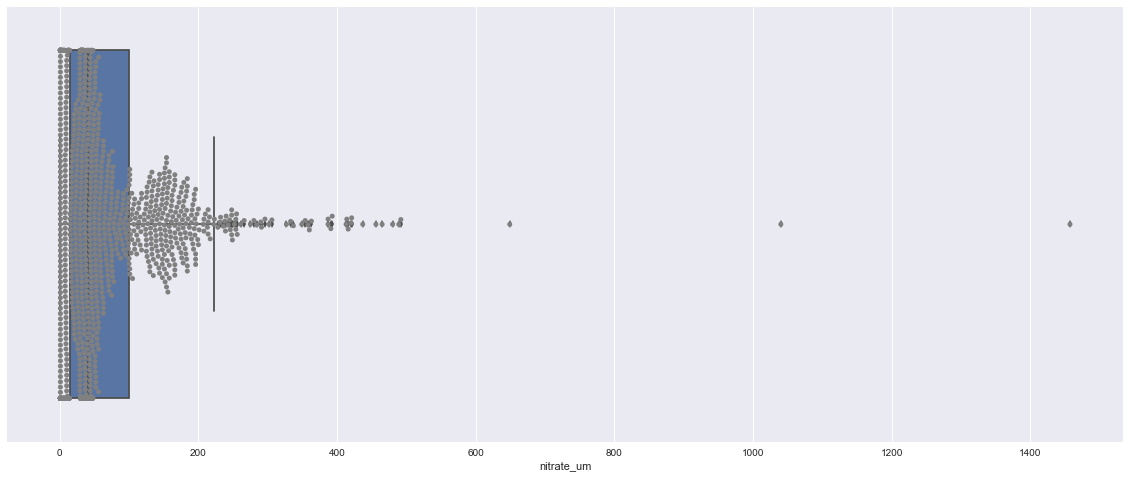

In [263]:
plt.figure(figsize=(20,8))
ax = sns.boxplot(df_plot['nitrate_um'].astype(float), orient='h')
ax = sns.swarmplot(df_plot['nitrate_um'].astype(float), orient='h', color='gray')

/Users/hritter/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



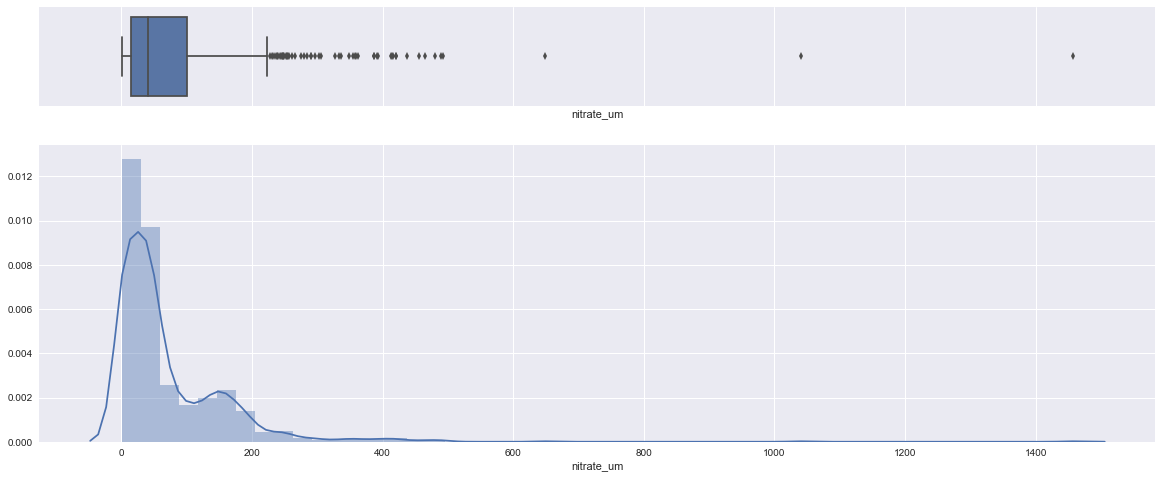

In [271]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.25, .75)}, figsize=(20,8))
ax_box = sns.boxplot(df_plot['nitrate_um'].astype(float), orient='h', ax=ax_box)
ax_hist = sns.distplot(df_plot['nitrate_um'].astype(float), ax=ax_hist)

/Users/hritter/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



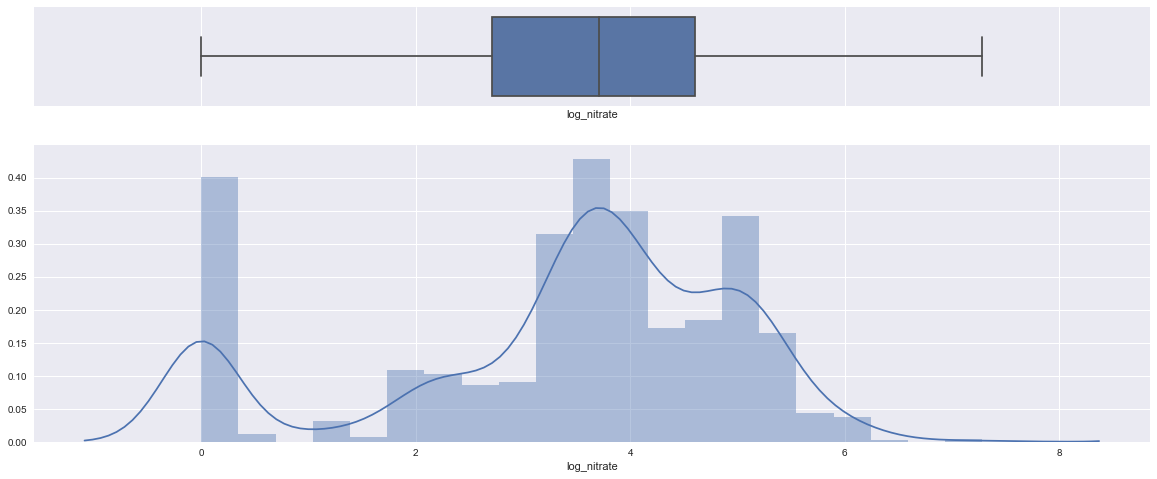

In [272]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.25, .75)}, figsize=(20,8))
ax_box = sns.boxplot(df_plot['log_nitrate'].astype(float), orient='h', ax=ax_box)
ax_hist = sns.distplot(df_plot['log_nitrate'].astype(float), ax=ax_hist)

# MODELING 

The report said that the plume is characterized by nitrate, chloride, and boron, so let's start with those.

### 3-D:

In [4]:
df = pd.read_pickle('raw_data.pkl')

In [5]:
df1 = df.iloc[:, [1,8,9,2,5,15]]

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1173 entries, 0 to 1285
Data columns (total 6 columns):
screen_alt_mid_ft    1173 non-null object
lat                  1173 non-null object
long                 1173 non-null object
nitrate_um           1173 non-null object
chloride_um          1173 non-null object
B_um                 1173 non-null object
dtypes: object(6)
memory usage: 64.1+ KB


In [7]:
df = df1.convert_objects(convert_numeric=True)

/Users/hritter/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [8]:
df.info() #here I'm noticing that the lat/long are not in numeric form, and in fact were not decimal lat/long 
#in the original table but looked like they were, so I'm converting them.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1173 entries, 0 to 1285
Data columns (total 6 columns):
screen_alt_mid_ft    1173 non-null float64
lat                  1173 non-null float64
long                 1173 non-null float64
nitrate_um           1173 non-null int64
chloride_um          1173 non-null int64
B_um                 1171 non-null float64
dtypes: float64(4), int64(2)
memory usage: 64.1 KB


In [9]:
def DMS_lat_to_dec(df):
    """dataframe, obs column,rim column"""
    df['lat2'] = df['lat']*100
    df.lat2 = df.lat2.astype(int)
    df.lat2 = df.lat2.astype(str)
    df['latS'] = df.lat2.str[-4:]
    df['latM'] = df.lat2.str[-6:-4]
    df['latD'] = df.lat2.str[-8:-6]
    df.latS = df.latS.astype(float)
    df.latM = df.latM.astype(float)
    df.latD = df.latD.astype(float)
    df['latS'] = df['latS']/100
    df['lat_dec'] = df['latD']+(df['latM']/60)+(df['latS']/3600)
    del df['lat2']
    del df['latS']
    del df['latM']
    del df['latD']
    return df

In [10]:
def DMS_long_to_dec(df):
    """dataframe, obs column,rim column"""
    df['long2'] = df['long']*100
    df.long2 = df.long2.astype(int)
    df.long2 = df.long2.astype(str)
    df['longS'] = df.long2.str[-4:]
    df['longM'] = df.long2.str[-6:-4]
    df['longD'] = df.long2.str[-8:-6]
    df.longS = df.longS.astype(float)
    df.longM = df.longM.astype(float)
    df.longD = df.longD.astype(float)
    df['longS'] = df['longS']/100
    df['long_dec'] = df['longD']+(df['longM']/60)+(df['longS']/3600)
    del df['long2']
    del df['longS']
    del df['longM']
    del df['longD']
    return df

In [11]:
DMS_long_to_dec(df)
DMS_lat_to_dec(df)

,screen_alt_mid_ft,lat,long,nitrate_um,chloride_um,B_um,long_dec,lat_dec
0,20.76,413700.98,703258.18,1,239,0.600,70.549494,41.616939
1,10.76,413700.98,703258.18,172,616,1.200,70.549494,41.616939
2,0.76,413700.98,703258.18,26,790,1.500,70.549494,41.616939
3,-9.24,413700.98,703258.18,60,336,1.000,70.549494,41.616939
5,-13.12,413701.00,703258.19,116,344,1.100,70.549497,41.616944
6,-14.12,413701.00,703258.19,125,349,1.100,70.549497,41.616944
7,-14.24,413700.98,703258.18,125,342,1.200,70.549494,41.616939
8,-15.12,413701.00,703258.19,132,365,1.200,70.549497,41.616944
9,-16.12,413701.00,703258.19,127,349,1.100,70.549497,41.616944
10,-18.12,413701.00,703258.19,133,414,1.700,70.549497,41.616944


In [204]:
df.dtypes

screen_alt_mid_ft    float64
lat                  float64
long                 float64
nitrate_um             int64
chloride_um            int64
B_um                 float64
long_dec             float64
lat_dec              float64
dtype: object

### Now I'm actually assigning X and Y variables for the model

In [13]:
X,y = df.drop(['chloride_um', 'nitrate_um', 'B_um', 'lat', 'long'], axis=1),df['nitrate_um']

In [14]:
y.max()

1457

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

notes on this gp1: This notebook doesn't show several hours of tweaking parameters (especially alpha) 

In [16]:
gp1 = GaussianProcessRegressor(n_restarts_optimizer=9, normalize_y = True, alpha = 1e-2)

In [17]:
gp1.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
             n_restarts_optimizer=9, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [18]:
y_pred, sigma = gp1.predict(X_test, return_std=True)

In [19]:
gp1.score(X_test,y_test)

-0.40526200037899529

In [20]:
gp1.score(X_train,y_train) #bad

0.3392843992448541

### Matern (exponential) kernel

In [21]:
kernel = Matern(nu=0.5)

In [62]:
gpM = GaussianProcessRegressor(n_restarts_optimizer=9, normalize_y = True, kernel=kernel, alpha=1e1)

In [23]:
gpM.fit(X_train, y_train)

/Users/hritter/anaconda/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


GaussianProcessRegressor(alpha=10.0, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=0.5), n_restarts_optimizer=9,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [24]:
y_predM, sigmaM = gpM.predict(X_test, return_std=True)

In [25]:
gpM.score(X_test,y_test)

0.0039513431494814233

In [26]:
gpM.score(X_train,y_train)

0.17701054889640833

In [27]:
yM_pred_frame = pd.DataFrame(y_predM, columns = ['ys_pred'])
sigmaM_frame = pd.DataFrame(sigmaM, columns = ['sigma'])
df_results = pd.concat([X_test.reset_index(), y_test.reset_index(), yM_pred_frame, sigmaM_frame], axis=1)
del df_results['index']
df_results.sort_values('long_dec', ascending=True, inplace=True)


,screen_alt_mid_ft,long_dec,lat_dec,nitrate_um,ys_pred,sigma
61,-28.37,70.539578,41.635686,36,72.353828,0.984437
268,-38.38,70.539578,41.635686,36,72.580658,0.999263
105,-58.36,70.539578,41.635686,31,77.806959,0.970996
320,-18.36,70.539578,41.635686,38,68.754284,0.997187
248,16.67,70.539578,41.635686,78,69.128128,0.997444
332,-3.16,70.539606,41.638236,18,81.884027,0.957093
17,-17.00,70.539647,41.634831,73,77.295435,0.989601
83,-25.58,70.539703,41.635322,37,70.540043,0.999543
135,-65.55,70.539703,41.635322,197,69.937550,0.966653
193,-57.58,70.539703,41.635322,53,71.303659,0.999821


In [28]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

In [53]:
trace = go.Scatter3d(
    x=df_results.long_dec, 
    y=df_results.lat_dec, 
    z=df_results.screen_alt_mid_ft,
    mode='markers',
    marker=dict(
        size=4,
        color = df_results.ys_pred, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)

In [54]:
data = [trace]

In [55]:
plotly.offline.iplot(data, filename = 'model1pred')

In [59]:
trace_real = go.Scatter3d(
    x=df_results.long_dec, 
    y=df_results.lat_dec, 
    z=df_results.screen_alt_mid_ft,
    mode='markers',
    marker=dict(
        size=4,
        color = df_results.nitrate_um, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)

In [60]:
data_real = [trace_real]

In [61]:
plotly.offline.iplot(data_real, filename = 'groundtruth')

### Running same GPR models, except on log data:

In [207]:
df['log_nitrate']=np.log(df['nitrate_um'])

In [209]:
Xlog,ylog = df.drop(['chloride_um', 'nitrate_um', 'B_um', 'lat', 'long', 'log_nitrate'], axis=1),df['log_nitrate']

In [211]:
Xlog_train, Xlog_test, ylog_train, ylog_test = train_test_split(Xlog, ylog, test_size=0.3)

In [252]:
gpM = GaussianProcessRegressor(n_restarts_optimizer=9, normalize_y = True, kernel=kernel, alpha=2)
#using the kernel that worked better, first

In [253]:
gpM.fit(Xlog_train, ylog_train)

/Users/hritter/anaconda/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning:

invalid value encountered in true_divide



GaussianProcessRegressor(alpha=2, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=0.5), n_restarts_optimizer=9,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [254]:
ylog_predM, sigmaM = gpM.predict(Xlog_test, return_std=True)

In [255]:
gpM.score(Xlog_test,ylog_test)

0.1513335960549328

In [256]:
gpM.score(Xlog_train,ylog_train)

0.16471631192044522

In [278]:
gp1 = GaussianProcessRegressor(n_restarts_optimizer=9, normalize_y = True, alpha = 1e1)
#now with the other one

In [279]:
gp1.fit(Xlog_train, ylog_train)

GaussianProcessRegressor(alpha=10.0, copy_X_train=True, kernel=None,
             n_restarts_optimizer=9, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [280]:
ylog_pred, sigma = gp1.predict(Xlog_test, return_std=True)

In [281]:
gp1.score(Xlog_test,ylog_test)

0.088032963336363679

In [282]:
gp1.score(Xlog_train,ylog_train)

0.16700710909958272

### Comparing to a Random Forest

In [297]:
dt1 = RandomForestRegressor()

In [298]:
dt1.fit(Xlog_train, ylog_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [299]:
ylog_pred_dt = dt1.predict(Xlog_test)

In [300]:
dt1.score(Xlog_test,ylog_test) #well.

0.49160440322207744

In [301]:
dt1.score(Xlog_train,ylog_train)

0.90943121370045443

In [290]:
ylog_predM_frame = pd.DataFrame(ylog_predM, columns = ['ylog_pred'])
sigmaM_frame = pd.DataFrame(sigmaM, columns = ['sigma'])
df_logresults = pd.concat([Xlog_test.reset_index(), ylog_test.reset_index(), ylog_predM_frame, sigmaM_frame], axis=1)
del df_logresults['index']
df_logresults.sort_values('long_dec', ascending=True, inplace=True)
df_logresults

,screen_alt_mid_ft,long_dec,lat_dec,log_nitrate,ylog_pred,sigma
35,-38.38,70.539578,41.635686,3.583519,4.185335,0.226588
333,-82.31,70.539578,41.635686,3.433987,3.276969,0.370908
127,1.64,70.539578,41.635686,3.784190,2.599242,0.239876
316,-57.10,70.539639,41.634836,3.465736,3.911152,0.227490
169,-24.27,70.539664,41.633064,5.017280,3.592561,0.251276
320,-119.65,70.539664,41.633075,3.135494,2.546580,0.438102
287,35.94,70.539667,41.633039,0.000000,3.505531,0.218341
251,-9.58,70.539703,41.635322,0.000000,3.024996,0.211173
314,14.42,70.539703,41.635322,0.693147,2.403979,0.217021
334,-17.58,70.539703,41.635322,2.484907,3.433722,0.216894


In [291]:
logtrace = go.Scatter3d(
    x=df_logresults.long_dec, 
    y=df_logresults.lat_dec, 
    z=df_logresults.screen_alt_mid_ft,
    mode='markers',
    marker=dict(
        size=4,
        color = df_logresults.ylog_pred, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)

In [293]:
logdata = [logtrace]

In [294]:
plotly.offline.iplot(logdata, filename = 'log-predictions1')

In [302]:
ydt_frame = pd.DataFrame(ylog_pred_dt, columns = ['ylog_pred_dt'])
df_logresultsdt = pd.concat([Xlog_test.reset_index(), ylog_test.reset_index(), ydt_frame], axis=1)
del df_logresultsdt['index']
df_logresultsdt.sort_values('long_dec', ascending=True, inplace=True)
df_logresultsdt

,screen_alt_mid_ft,long_dec,lat_dec,log_nitrate,ylog_pred_dt
35,-38.38,70.539578,41.635686,3.583519,3.569498
333,-82.31,70.539578,41.635686,3.433987,4.042246
127,1.64,70.539578,41.635686,3.784190,3.040784
316,-57.10,70.539639,41.634836,3.465736,2.893169
169,-24.27,70.539664,41.633064,5.017280,3.496821
320,-119.65,70.539664,41.633075,3.135494,1.275345
287,35.94,70.539667,41.633039,0.000000,2.770977
251,-9.58,70.539703,41.635322,0.000000,2.685556
314,14.42,70.539703,41.635322,0.693147,2.814279
334,-17.58,70.539703,41.635322,2.484907,3.492045


In [303]:
dttrace = go.Scatter3d(
    x=df_logresultsdt.long_dec, 
    y=df_logresultsdt.lat_dec, 
    z=df_logresultsdt.screen_alt_mid_ft,
    mode='markers',
    marker=dict(
        size=4,
        color = df_logresultsdt.ylog_pred_dt, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)

In [304]:
datadt = [dttrace]

In [305]:
plotly.offline.iplot(datadt, filename = 'log-predictions-forest')

In [306]:
log_trace_real = go.Scatter3d(
    x=df_logresultsdt.long_dec, 
    y=df_logresultsdt.lat_dec, 
    z=df_logresultsdt.screen_alt_mid_ft,
    mode='markers',
    marker=dict(
        size=4,
        color = df_logresultsdt.log_nitrate, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)

In [307]:
data_real = [log_trace_real]

In [308]:
plotly.offline.iplot(data_real, filename = 'groundtruth')